## Import Libraries

In [33]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [34]:
stock_intc = pd.read_csv('../../../Dataset/INTC.csv')
stock_intc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [35]:
# Convert the 'Date' column to datetime format
stock_intc['Date'] = pd.to_datetime(stock_intc['Date'])

# Set the 'Date' column as the index value
stock_intc = stock_intc.set_index(pd.DatetimeIndex(stock_intc['Date'].values))

# Create new datafram with Date and Close
stock_intc = pd.DataFrame(stock_intc, columns=['Close'])

### Convert from Series to Supervised

In [36]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [37]:
# n_in : 5  : Observation in the past
n_in = 5
# n_out: 1: Predict in the future
n_out = 1

In [38]:
# Get Values
values = stock_intc.values

# Convert to supervised
data_supervised = series_to_supervised(values, n_in, n_out)

### Data splitting

In [39]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(stock_intc) * 0.6)
val_size = int(len(stock_intc) * 0.2)
test_size = len(stock_intc) - train_size - val_size

In [40]:
# Get Data
train_data = data_supervised[:train_size]
val_data = data_supervised[train_size:train_size+val_size]
test_data = data_supervised[train_size+val_size:]

# Make input
X_train, y_train = train_data[:, :-n_out], train_data[:, -n_out:]
X_val, y_val = val_data[:, :-n_out], val_data[:, -n_out:]
X_test, y_test = test_data[:, :-n_out], test_data[:, -n_out:]

## Model training and testing

In [41]:
# Define Model
    # objective: Config Loss Function: mean squared error (MSE)
    # n_estimators: Number Of Decision Tree: 1000
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators= 1000, 
)

In [42]:
# Training XgBoost model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds = 10)

[0]	validation_0-rmse:32.73709
[1]	validation_0-rmse:22.49282
[2]	validation_0-rmse:15.53098
[3]	validation_0-rmse:10.67733
[4]	validation_0-rmse:7.44433
[5]	validation_0-rmse:5.33411
[6]	validation_0-rmse:4.00089
[7]	validation_0-rmse:3.22994
[8]	validation_0-rmse:2.72746
[9]	validation_0-rmse:2.46576
[10]	validation_0-rmse:2.34727
[11]	validation_0-rmse:2.33886
[12]	validation_0-rmse:2.37683
[13]	validation_0-rmse:2.38272
[14]	validation_0-rmse:2.41456
[15]	validation_0-rmse:2.44125
[16]	validation_0-rmse:2.46203
[17]	validation_0-rmse:2.46603
[18]	validation_0-rmse:2.50769
[19]	validation_0-rmse:2.51573
[20]	validation_0-rmse:2.52095
[21]	validation_0-rmse:2.51681


n:\UIThoc\Nam3\Anaconda\envs\user_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Testing process

In [43]:
# Predict
y_pred = model.predict(X_test)

### Evaluate model

In [44]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.3175762245798326
Testing RMSE:  14.030793125487003
Testing MSLE:  0.14902685217848874


## Predicting the next 30 days

### Preparing the prediction data

In [45]:
future_features = data_supervised[:, :-n_out] 

prediction_next30_days = []  # Danh sách dự đoán giá Close

for _ in range(30):
    # Predict Close 
    y_pred_30day = model.predict(future_features)
    prediction_next30_days.append(y_pred_30day[0])  # Get values

    # Create a new data for input of model
    future_features = np.roll(future_features, -1, axis=1)
    future_features[:, -5] = y_pred_30day

In [46]:
# Print predict next 30 days
print(prediction_next30_days)

[47.721283, 46.778122, 47.85665, 46.119133, 47.594494, 46.119133, 46.651333, 46.119133, 45.811543, 45.856976, 45.811543, 45.811543, 45.444138, 45.811543, 45.233456, 45.035698, 45.4835, 44.825016, 45.07506, 44.244526, 45.07506, 44.09728, 45.07506, 43.98704, 45.07506, 43.98704, 45.07506, 43.98704, 45.07506, 43.98704]


### Preparing the forecast date index

In [47]:
# Get the last date from the current index
last_date = stock_intc.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

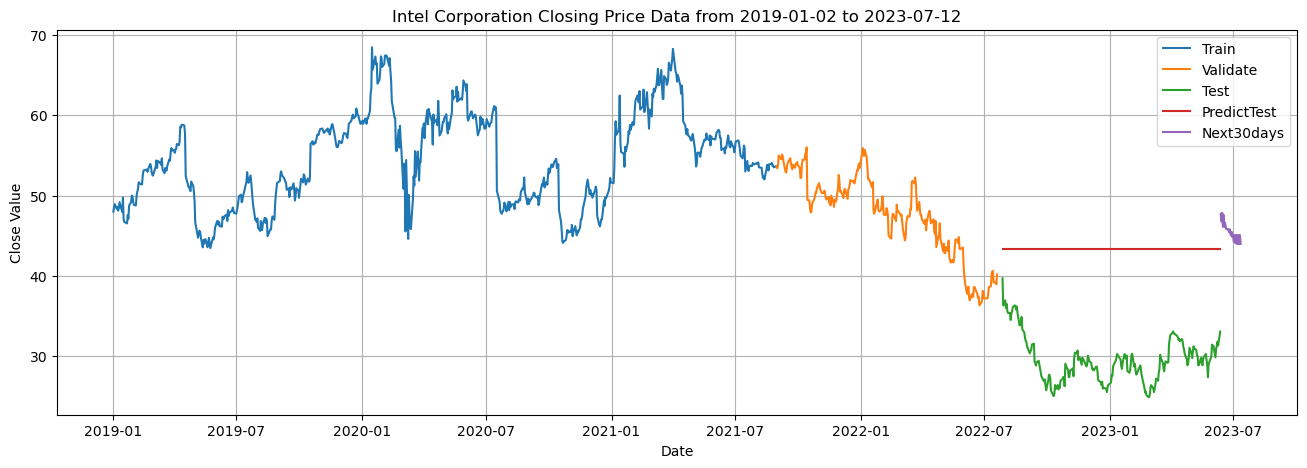

In [48]:
plt.figure(figsize=(16,5))

plt.plot(stock_intc.index[:train_size], y_train)

plt.plot(stock_intc.index[train_size: train_size + val_size], y_val)

plt.plot(stock_intc.index[train_size + val_size + n_in: train_size + test_size + val_size], y_test)

plt.plot(stock_intc.index[train_size + val_size + n_in: train_size + test_size + val_size], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Intel Corporation Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/XgBoost_622_INTC.png')
plt.show()